<a href="https://colab.research.google.com/github/tugcegurbuz/AI/blob/master/BeamSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Explanation: Using Beam Search to solve 8 puzzle problem**

**Group Members:**

Arash Ashrafnejad,  Ege Darçın, Emre Erdemoğlu, Tuğçe Gürbüz 

---

*Problem: The 8-puzzle is a game in which there are eight 1x1 tiles arranged on a 3x3 square so that there is one 1x1 uncovered (empty) area on the square. The tiles are labeled 1 through 8, and initially they are shuffled. The idea is to reach the goal statefrom a given initial state by moving tiles one at a time*

**The following two code cells are utilized to construct the program in Google Colab environment.**

__Note:__ Anytree is an library which allows easy construction and management of trees.

In [0]:
!pip install anytree
!pip install pydot
!pip install graphviz
!apt-get install graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


In [0]:
import random
import psutil
import numpy as np
from google.colab import files
from IPython.display import Image
from anytree import NodeMixin, RenderTree, Walker
from anytree.exporter import DotExporter

**About MyNode:**

MyNode is an extension of anytree library, which is a library to construct trees at ease. It is extended to accomodate the following:

*   ***cost:*** The cost value that is to be minimized. Heuristic function that generates the cost in this project is the ***Number of displaced tiles.***
*   ***i:*** The count of the jumps that took place. Root node has jump count 0.
*   ***s:*** The 9-puzzle matrix. It has size 4x3 where elements (i,j) = (0,1) and (0,2) are marked by 'x' since those locations are inaccessible due to question constraints. 
*   ***parent:*** Holds the parent of this node

__Note_1:__ Values from 1 to 8 in puzzle matrix "s" denote name of the squares in those coordinates. A value of "0" implies that the particular coordinate is empty.

__Note_2:__ The 9-puzzle configuration is hard-coded here, since the question only asks about solving this particular problem. Therefore, no global variables are assigned.

In [0]:
class MyNode(NodeMixin):  # Extend node features (cost, name, cell array)
  def __init__(self, s, i=0, cost=0, parent=None):
    self.cost = cost
    self.i = i
    self.s = []
    
    # Deep copy a given puzzle matrix to this object
    for i in range(4):
      self.s.append(s[i][:])
    
    # Name yourself and set your parent
    self.name = str(self)
    self.parent = parent
   
  # For representing the object in string form:
  def __str__(self):
    text = '\n'.join(['\t'.join([str(cell) for cell in row]) for row in self.s])
    text = text.replace('0', ' ')
    text =  '%d: cost = %d \n'%(self.i, self.cost) + text
    return text
  

  def find(self, value):
    """Returns the (x,y) coordinates of the specified value 
       in the 9-puzzle matrix"""
    if value < 0 or value > 9:
      raise Exception("Invalid Value - Out of Range")

    for row in range(4):
      for col in range(3):
        if self.s[row][col] == value:
            return row, col
              
  def _get_legal_moves(self):
    """Returns valid list of tuples which free space can be swapped"""
    
    row, col = self.find(0)   # Get (x,y) coordinates of the free space
    free = []                 # Open up an empty list of legal moves

    # Puzzle constraints: 
    # Find which pieces can move to the free space ('+' like movement)
    # (Left, Right, Up & Down)
    # Mind the boundaries of the box!
    if row > 0:
      free.append((row - 1, col)) # up
    if col > 0:
      free.append((row, col - 1)) # left
    if row < 3:
      free.append((row + 1, col)) # down
    if col < 2:
      free.append((row, col + 1)) # right
        
    # Remove the blocked moves from the legal set of moves, return afterwards
    if (row == 0 and col == 0):
      free.remove((0, 1))
      
    if (row == 1 and col == 1):
      free.remove((0, 1))
      
    if (row == 1 and col == 2):
      free.remove((0, 2))

    return free
  
  def shuffle(self, step_count):
    """Returns a new puzzle that is made of by shuffling another puzzle"""
    
    # Do not touch coordinates (0,1) and (0,2) -- Puzzle constraint
    # Step count: Shuffle a single element 
    for i in range(step_count):
      row, col = self.find(0)           # Find coord. of free cell
      free = self._get_legal_moves()    # Get valid moves around free cell
      target = random.choice(free)      # Randomly select a cell, since problem 
      self.swap((row, col), target)     # is not solved, no need for heuristic.        
      row, col = target                 # Swap empty with target, updt. coords.
    return self.s
        
  def peek(self, row, col):
    """Returns the value at the specified coordinate (x,y)"""
    return self.s[row][col]

  def poke(self, row, col, value):
    """Sets the value at the specified coordinate (x,y)"""
    self.s[row][col] = value

  def swap(self, pos_a, pos_b):
    """Swaps values at the specified coordinates p1(x1,y1) and p2(x2,y2)"""
    temp = self.peek(*pos_a)
    self.poke(pos_a[0], pos_a[1], self.peek(*pos_b))
    self.poke(pos_b[0], pos_b[1], temp)
      
  def move(self, pos_b):
    """Finds the empty cell position as a tuple, swaps with 
    given coordinate tuple (pos_a swapped with pos_b (in 2D))"""
    pos_a = self.find(0)
    self.swap(pos_a, pos_b)

***Puzzle Generator:***

Starting from the goal state, we garbled the puzzle to an initial state. This was done in order to make sure that the puzzle is solveable. We could randomly generate a puzzle, but however in that case the puzzle may not be solveable anymore.

__Note_1:__ This part also provides a textual listing for all 25 distinct initial states of the shuffled puzzle along with the goal state of the puzzle (at the beginning).

__Note_2:__ Note that the cost and the name of the states are not initialized at this point, since they are not needed. One of these 25 distinct states will be chosen first and then a starting state (root node) will be created. The name and the cost will be assigned at that point.

In [0]:
# Generate initial puzzles by using the goal state(solution):
# "s" is the solution puzzle matrix here.

shuffled_matrices = []
# Now generate 25 distinct initial states:
# First shuffle, then check with previous matrices; compare whether new shuffle
# from the goal matrix is unique in the list.
print("Shuffled initial (solveable) states:")
i = 0 # np array list dimension
while(i <= 25):
    goal = MyNode(s=[[0,'x','x'], [1, 2, 3], [4, 5, 6], [7, 8, 9]])
    # Create a numpy array that holds the candidates (currently we have none)
    candidate_matrix = goal.shuffle(6) # 10 moves made to shuffle
    if candidate_matrix not in shuffled_matrices:
      shuffled_matrices.append(candidate_matrix) 
      i+=1

Shuffled initial (solveable) states:


**In the code segment below, the textual listing of the 25 distinct initial (solveable) states are given.**

__Note 1:__ Additionally a random number between

In [0]:
print("Textual Listing of all 25 Distinct Solveable Initial States:" + "\n")
for m in range(0,25):
  print("Initial state #" + str(m))
  print(shuffled_matrices[m]) 
  print()


Textual Listing of all 25 Distinct Solveable Initial States:

Initial state #0
[[1, 'x', 'x'], [4, 2, 3], [7, 5, 6], [8, 0, 9]]

Initial state #1
[[0, 'x', 'x'], [1, 2, 3], [4, 5, 6], [7, 8, 9]]

Initial state #2
[[1, 'x', 'x'], [4, 2, 3], [5, 8, 6], [7, 0, 9]]

Initial state #3
[[1, 'x', 'x'], [4, 2, 3], [0, 5, 6], [7, 8, 9]]

Initial state #4
[[1, 'x', 'x'], [2, 0, 3], [4, 5, 6], [7, 8, 9]]

Initial state #5
[[0, 'x', 'x'], [1, 4, 3], [5, 2, 6], [7, 8, 9]]

Initial state #6
[[1, 'x', 'x'], [2, 3, 6], [4, 5, 0], [7, 8, 9]]

Initial state #7
[[1, 'x', 'x'], [4, 2, 3], [5, 6, 0], [7, 8, 9]]

Initial state #8
[[1, 'x', 'x'], [4, 2, 3], [5, 8, 0], [7, 9, 6]]

Initial state #9
[[1, 'x', 'x'], [2, 0, 5], [4, 6, 3], [7, 8, 9]]

Initial state #10
[[1, 'x', 'x'], [4, 0, 3], [5, 2, 6], [7, 8, 9]]

Initial state #11
[[1, 'x', 'x'], [4, 0, 3], [7, 2, 6], [8, 5, 9]]

Initial state #12
[[1, 'x', 'x'], [2, 5, 3], [0, 8, 6], [4, 7, 9]]

Initial state #13
[[1, 'x', 'x'], [2, 5, 3], [4, 8, 6], [7, 0, 9

***Solver algorithm: - Beam Search***

__Note:__ Note that the heuristic function used in this solver is the number of displaced tiles (h1).

In [0]:
## TODO ####################################
## Add method explanation """comments"""
MAX_STATE_JUMP = 100000000           # Terminate possible infinite loops
class beam_solver:
  
  def __init__(self, goal_state, puzzle):
    # Solver has a goal to reach, give it that. Goal is a MyNode with name and 
    # cost 0 and without a parent.
    self.goal_state = goal_state
    self.goal_node = MyNode(goal_state)
    
    temp_node = MyNode(goal_state)
    cost = self.calculate_dist(puzzle)
    self.init_node = MyNode(puzzle, 0, cost)
    
    self.i = 0 #index of children
    
  # Same approach as first homework; set an initial node, and pick next moves.
  # This time beam number is given by w. Solver also has to act accordingly.
  # This is basically, do a breadth first search and pick best two to continue
  # with at the next level of search until goal is found (or memory is full)
  
  def expand(self, parent_node):
    moves = parent_node._get_legal_moves()
    children = []
    num_total_movements = 0 
    notFound = True
    for m in moves:
        
        temp_node = MyNode(parent_node.s)        # Get a temp node to play with
        temp_node.move(m)                        # Do your move on playground
        
        dist = self.calculate_dist(temp_node.s)  # Evaluate cost metric
#         print(dist)
                   
        new_node = MyNode(temp_node.s, self.i, dist, parent=parent_node)
        if dist == 0:
          notFound = False
          print('Found it')
          solution_path = new_node.ancestors
          num_total_movements = len(solution_path)
        
        self.i += 1
        
        children.append(new_node)
        
    for node in children:
      notLoop = self.checkParentData(node)
      if not notLoop:
#         print('removed loop')
        children.remove(node)
        
    return children, notFound, num_total_movements
  
  def checkParentData(self, node):
    """checking matrices of ancestors in order to detect loops""" 
    parents = node.anchestors 
    for parent in parents:
      #if any matrices match, return false else return true
      if (parent.s==node.s):
#         print('loop!')
        return False
    return True
     
  def find_next_parents(self, level_leaves, w):
    w = min(w, len(level_leaves))
#     print(w)
    parent_nodes = []
    for i in range(0, w):
      min_node = level_leaves[0] 
      for node in level_leaves:
        cost = node.cost
        if cost < min_node.cost:
          min_node = node
          
      parent_nodes.append(min_node)
      level_leaves.remove(min_node)
    return parent_nodes
    
    
  
  def solve(self, w):
    parent_node = self.init_node

    self.level_leaves, not_found, total_movement = self.expand(parent_node) #Queue of leaves of one specific depth
    self.parent_nodes = self.find_next_parents(self.level_leaves, w) #Queue of best w leaves
    not_found = True
    while (not_found and self.i<MAX_STATE_JUMP):
      self.level_leaves = []
      
      for node in self.parent_nodes:
          
        new_nodes, not_found, total_movement = self.expand(node)
        self.level_leaves += new_nodes
        if len(new_nodes) == 0:
          del node
        
        if not not_found:
          break
      if not not_found:
        break
        
      if len(self.level_leaves)==0:
        print('Solution not found, backtrace is required!')
        return 0
      else:
        self.parent_nodes = self.find_next_parents(self.level_leaves, w)
   
      
    return self.i

  def calculate_dist(self, m):
    #calculates number of displaced tiles
    dist_from_goal =(np.sum(np.array(m) != np.array(self.goal_node.s)))
    return dist_from_goal
              
  def display(self):
    DotExporter(self.init_node).to_picture("solution.png")
    display(Image("solution.png"))
    files.download('solution.png') 
    

***TODO***

Found it


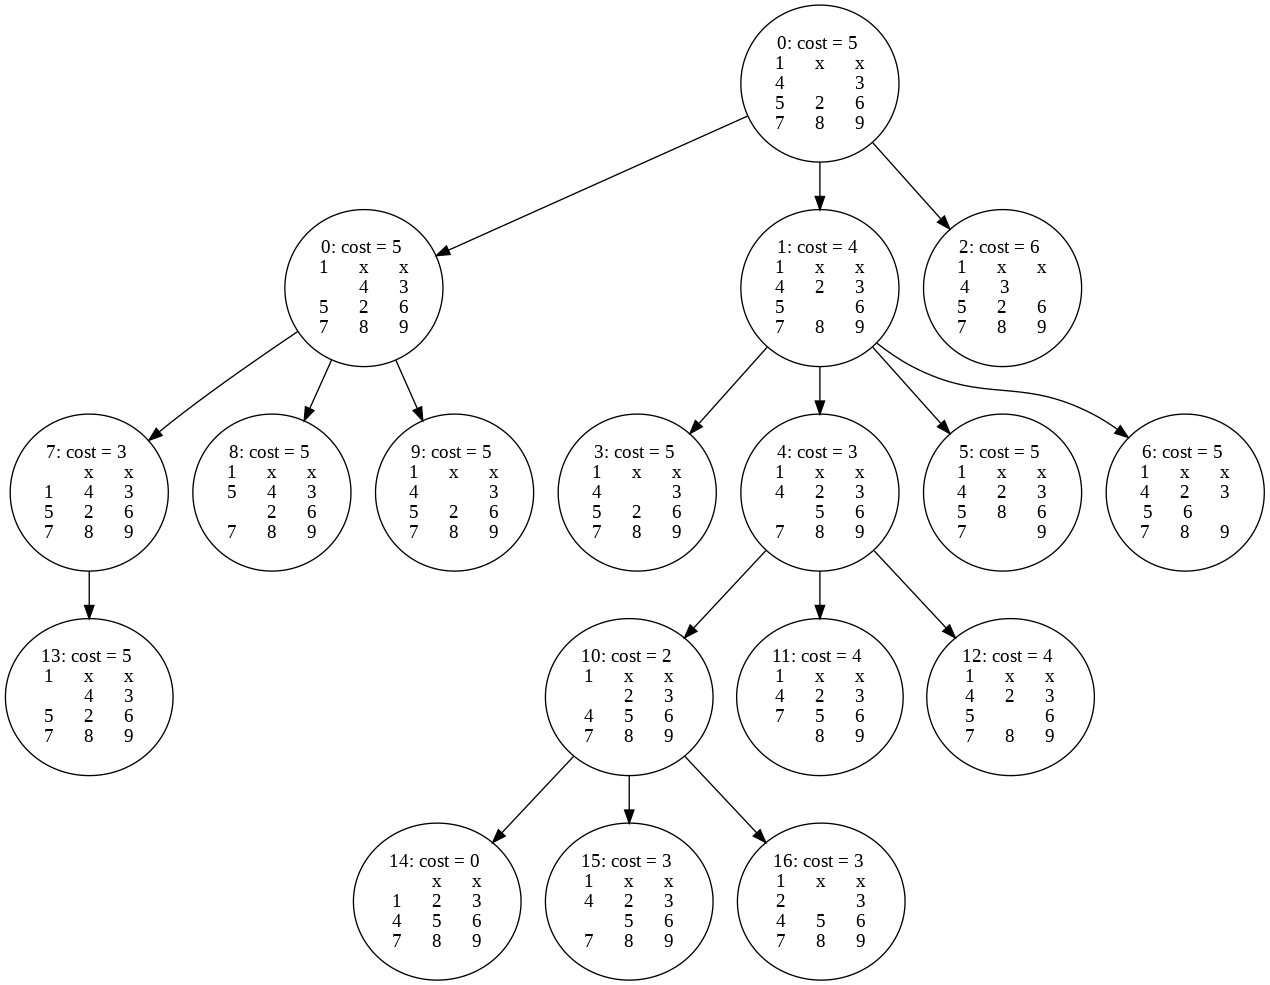

In [0]:
g = [[0,'x','x'], [1, 2, 3], [4, 5, 6], [7, 8, 9]]
matrix = shuffled_matrices[10]
p = beam_solver(g, matrix)
total_movement_w3 = p.solve(2)
p.display()

[[1, 'x', 'x'], [2, 0, 3], [4, 5, 6], [7, 8, 9]]
Found it
Found it
[[0, 'x', 'x'], [1, 2, 3], [4, 5, 6], [7, 8, 9]]
Found it
Found it
[[1, 'x', 'x'], [4, 2, 3], [5, 6, 0], [7, 8, 9]]
Found it
Found it
[[1, 'x', 'x'], [4, 2, 3], [7, 5, 6], [8, 0, 9]]
Found it
Found it
[[1, 'x', 'x'], [2, 5, 3], [4, 8, 6], [7, 0, 9]]
Found it
Found it
[[1, 'x', 'x'], [4, 2, 3], [0, 5, 6], [7, 8, 9]]
Found it
Found it
[[1, 'x', 'x'], [2, 3, 6], [4, 5, 0], [7, 8, 9]]
Found it
Found it
[[1, 'x', 'x'], [4, 0, 3], [5, 2, 6], [7, 8, 9]]
Found it
Found it
[[1, 'x', 'x'], [4, 2, 3], [7, 5, 0], [8, 9, 6]]
Found it
Found it
[[1, 'x', 'x'], [2, 5, 3], [4, 6, 0], [7, 8, 9]]
Found it
Found it
[[1, 'x', 'x'], [2, 5, 3], [0, 4, 6], [7, 8, 9]]
Found it
Found it
[[1, 'x', 'x'], [2, 5, 3], [7, 4, 6], [8, 0, 9]]
Found it
Found it
[[1, 'x', 'x'], [5, 0, 3], [2, 4, 6], [7, 8, 9]]
Found it
Found it
[[0, 'x', 'x'], [1, 5, 3], [2, 4, 6], [7, 8, 9]]
Found it
Found it
[[1, 'x', 'x'], [4, 2, 3], [0, 8, 6], [5, 7, 9]]
Found it
Foun

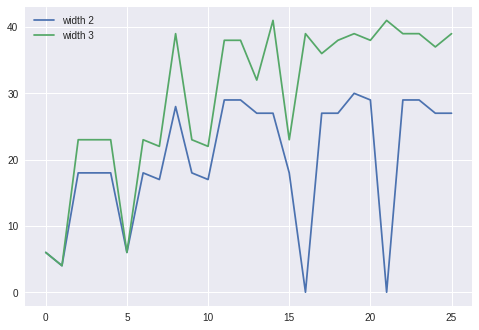

In [0]:
import matplotlib.pyplot as plt

g = [[0,'x','x'], [1, 2, 3], [4, 5, 6], [7, 8, 9]] # goal list

movements_w2 = []
movements_w3 = []

for matrix in shuffled_matrices:
  print(matrix)
  p = beam_solver(g, matrix)
  total_movement_w3 = p.solve(3)
  
  p1 = beam_solver(g, matrix)
  total_movement_w2 = p1.solve(2)
  movements_w2.append(total_movement_w2)
  movements_w3.append(total_movement_w3)

plt.plot(movements_w2, label='width 2')
plt.plot(movements_w3, label='width 3')
plt.legend()
plt.show()